In [334]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Task 1:** The LDA model

Imports

In [335]:
!pip install pymc
import pymc as pm
import numpy as np
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import arviz as az

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading from files

The topics were chosen to cover narrow domains, as to increase the probability of finding more shared words between the documents of the same topic. The documents, also, are large, but are reduced to the most common n words for the same exact reason.

In [336]:
folder="/content/gdrive/My Drive/Project1_PP"

topic0 = open(folder+"/epilepsy.txt","r").readlines()
topic1 = open(folder+"/neural_networks.txt","r").readlines()
topic2 = open(folder+"/stars.txt","r").readlines()

topics = [topic0, topic1, topic2]

#The true labels
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

Text processing

In [337]:
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [338]:
documents = []
for topic in topics:
  topic = list(filter(lambda a: a != '\n', topic))
  for document in topic:
    doc = document[:-1]   #getting rid of \n at the end
    doc = doc.lower()
    tokens = word_tokenize(doc)

    #tokens, without punctuation and stop words, and with stemming
    tokens_new = [ps.stem(x) for x in tokens if (x not in string.punctuation and x not in stop_words and ps.stem(x).isalpha())]      
    documents.append(tokens_new)

Keeping the n most common words from each document in an attempt to keep the shared elements between the documents of the same topic, and at the same time rushing the learning process

In [339]:
documents_trun = []
n_most_common = 10
for document in documents:
  d = Counter(document)
  if len(d.keys()) <= n_most_common:
    documents_trun.append(list(d.keys()))
  else:
    documents_trun.append([word for word, nr in d.most_common(n_most_common)]) 

Building the dictionary

In [340]:
dictionary = {}
for document in documents_trun:
  for word in document:
    if word not in dictionary.keys():
      dictionary[word] = len(dictionary.keys())

Transforming the documents into numerical sequences

In [341]:
doc_numerical = []
for document in documents_trun:
  doc_numerical.append([dictionary[x] for x in document])

Training the model

In [342]:
#number of topics  
K = 3  
   
#number of words
V = len(dictionary.keys())  
   
#number of documents  
D = len(doc_numerical)  
   
#array([1, 1, 1, ..., 1]) K times  
alpha = np.ones(K) 
   
#array([1, 1, 1, ..., 1]) V times  
beta = np.ones(V)  

n_iter = 5000
burn = 0
   
#array containing the information about doc length in our collection
Nd = [len(doc) for doc in doc_numerical]  
   
   
 ######################## LDA model ##################################  
   
#topic distribution per-document   
aux_1 = pm.Container([pm.Dirichlet("ptheta_%s"%i, theta=alpha) for i in range(D)])
theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, aux_1[i]) for i in range(D)])
   
#word distribution per-topic      
aux_2 = pm.Container([pm.Dirichlet("pphi_%s" % j, theta=beta) for j in range(K)])
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % j, aux_2[j]) for j in range(K)])

 
z = pm.Container([pm.Categorical("z_%i" % d,  
                                  p = theta[d],  
                                  size = Nd[d],  
                                  value = np.random.randint(K, size=Nd[d]))   #results [0, K)
                   for d in range(D)])  
   
#word generated from phi, given a topic z  
w = pm.Container([pm.Categorical("w_%i_%i" % (d,i),  
                                  p = pm.Lambda("phi_z_%i_%i" % (d,i),  
                                                lambda z=z[d][i], phi=phi : phi[z]),
                                  value=doc_numerical[d],  
                                  observed=True)  
                   for d in range(D) for i in range(Nd[d])])  
   
 ####################################################################  
   
model = pm.Model([aux_1, theta, aux_2, phi, z, w])  
mcmc = pm.MCMC(model)  
mcmc.sample(iter=n_iter, burn=burn)  
   

z_last = []
for d in range(D):
  z_last.append(mcmc.trace('z_%i'%d)[n_iter-1-burn])

print("\n")  
print("Value of z: ")
for d in range(D):
  print(z_last[d])

Topic = pm.Container([max(Counter(z_last[d]), key=Counter(z_last[d]).get) for d in range(D)])
print('\n')
print("Predicted topics: {}".format(Topic))

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 5000 of 5000 complete in 34.2 sec

Value of z: 
[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0]
[2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]


Predicted topics: [1, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 0, 1, 2, 2]


**Plotting traces for all iterations, for the model variables**

The "error" will be the difference between the variable at iteration i and iteration i-1. The more the model learns, the smaller the difference will get with each iteration

In [343]:
theta_last = np.array([mcmc.trace("theta_%s" % j)[0] for j in range(D)])
phi_last = np.array([mcmc.trace("phi_%s" % j)[0] for j in range(K)])
z_last = np.array([mcmc.trace('z_%i'%d)[0] for d in range(D)])

theta_err = []
phi_err = []
z_err = []

for i in range(1, n_iter-burn):
  theta_new = np.array([mcmc.trace("theta_%s" % j)[i] for j in range(D)])
  phi_new = np.array([mcmc.trace("phi_%s" % j)[i] for j in range(K)])
  z_new = np.array([mcmc.trace('z_%i'%d)[i] for d in range(D)])

  theta_err.append(np.mean(abs(theta_new-theta_last)))
  phi_err.append(np.mean(abs(phi_new-phi_last)))
  z_err.append(np.mean(abs(z_new-z_last)))

  theta_last = theta_new
  phi_last = phi_new
  z_last = z_new

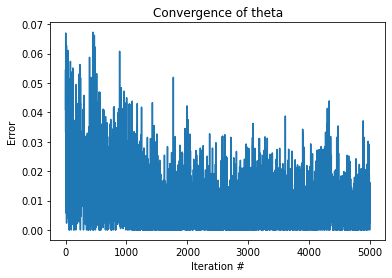

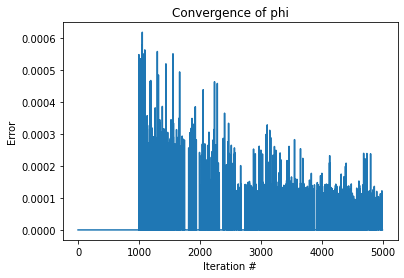

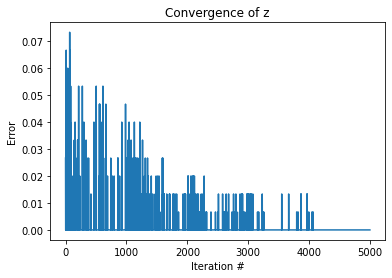

In [344]:
plt.figure()


plt.plot(theta_err)
plt.xlabel("Iteration #")
plt.ylabel("Error")
plt.title("Convergence of theta")
plt.show()

print("\n")

plt.plot(phi_err)
plt.xlabel("Iteration #")
plt.ylabel("Error")
plt.title("Convergence of phi")
plt.show()

print("\n")

plt.plot(z_err)
plt.xlabel("Iteration #")
plt.ylabel("Error")
plt.title("Convergence of z")
plt.show()

"We use the posterior topic proportions "theta"
and posterior topic assignments "z" to visualize the underlying topic decomposition of a document. Plotting the posterior topic proportions gives a
sense of which topics the document is “about.” These vectors can also be
used to group articles that exhibit certain topics with high proportions."

source: http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf

/usr/local/lib/python3.7/dist-packages/arviz/data/base.py:221: UserWarning: More chains (15) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/base.py:221: UserWarning: More chains (15) than draws (10). Passed array should have shape (chains, draws, *shape)
  UserWarning,


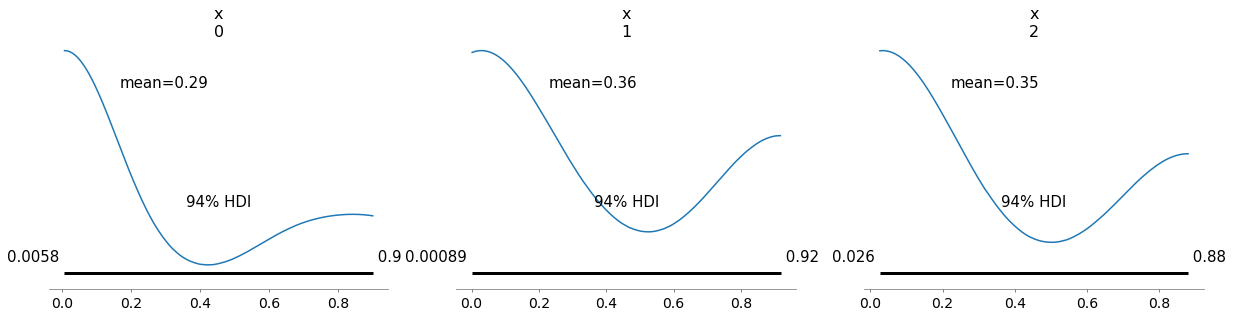

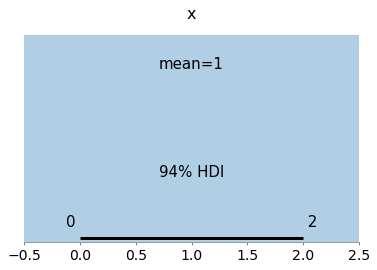

In [345]:
theta = np.array([mcmc.trace("theta_%s" % j)[n_iter-1-burn] for j in range(D)])
z = np.array([mcmc.trace('z_%i'%d)[i] for d in range(D)])

az.plot_posterior(theta)
print("\n \n")
az.plot_posterior(z)

Calculating the accuracy, method 1: by counting how many predictions are equal to the true labels

In [346]:
acc1 = sum([Topic[i] == labels[i] for i in range(len(labels))])/len(labels)
print("Accuracy 1: {}".format(acc1))

Accuracy 1: 0.5333333333333333


Calculating the accuracy, method 2: by counting the predicted probabilities that certain documents belong to the correct topic

In [347]:
accuracies = []

for d in range(D):
  accuracies.append(Counter(z_last[d])[labels[d]]/len(z_last[d]))

acc2 = np.mean(accuracies)
print("Accuracies for each document: {}".format(accuracies))
print("Mean accuracy: {}".format(acc2))

Accuracies for each document: [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
Mean accuracy: 0.5333333333333333


**Task 2:** 

**Topic-based similarity:** It is better to keep as many words as possible from documents in order to accurately determine the topic-based similarity between documents, because the most frequent n, where n is a small number, words in each document might not share any same elements

In [348]:
#Lets find the iteration where the z[i] does not have constant values (z[i] is a constant list of same topic for all 
#words when it reaches a certain number of iterations)

for i in range(n_iter-1-burn, 0, -1):
  z_sim = []
  for d in range(D):
    z_aux = mcmc.trace('z_%i'%d)[i]
    count = Counter(z_aux)
    if len(count.keys()) != K:                       #we want to find a z[i] where all K topics are present
      z_sim.append(z_aux)
      break
    else:
      z_sim.append(z_aux)


if len(z_sim)!=D:
  for i in range(n_iter-1-burn, -1, -1):
    z_sim = []
    for d in range(D):
      z_aux = mcmc.trace('z_%i'%d)[i]
      count = Counter(z_aux)
      if len(count.keys()) != K-1:                       #we want to find a z[i] where K-1 topics are present
        z_sim.append(z_aux)
        break
      else:
        z_sim.append(z_aux)

#If we can't find a z where the topics in each document vary enough
if len(z_sim)!=D:
  for d in range(D):
    z_sim.append(mcmc.trace('z_%i'%d)[1])

for i in range(len(z_sim)):
  print(z_sim[i])      

[2 1 2 0 2 2 1 0 1 0]
[0 1 0 0 2 1 1 2 2 1]
[2 0 0 2 0 1 2 1 0 2]
[0 0 1 2 2 1 0 0 2 1]
[2 2 0 0 2 2 0 1 0 1]
[2 1 1 0 2 1 2 0 1 2]
[2 1 1 0 1 0 2 2 1 2]
[2 1 1 0 0 2 1 0 1 1]
[1 1 1 0 1 1 2 0 0 1]
[0 1 0 0 2 0 0 2 2 0]
[0 1 0 0 1 2 0 1 0 0]
[2 1 2 1 1 1 2 0 1 0]
[1 2 2 2 0 0 1 0 1 0]
[0 0 2 2 2 1 2 0 1 0]
[1 2 2 1 0 1 2 0 0 1]


In [349]:
#Lets find the similarity between the documents:

#number of documents for each topic
L = 5

#Pick 2 documents for calculating their similarity
#We will pick randomly
ids = np.random.randint(0, L*K, 2)

count1 = Counter(z_sim[ids[0]])
print()
count2 = Counter(z_sim[ids[1]])

total = 0
for k in range(K):
  minimum = min(count1[k], count2[k])
  total += minimum                                               #add how many words of same topic there are in common

similarity = total/n_most_common

print("Document ids: {}, {}".format(ids[0], ids[1]))
print("Documents: {}, {}".format(z_sim[ids[0]], z_sim[ids[1]]))
print("Similarity: {}".format(similarity))

#similarity = 1 means very similar, but not identical!


Document ids: 8, 0
Documents: [1 1 1 0 1 1 2 0 0 1], [2 1 2 0 2 2 1 0 1 0]
Similarity: 0.7


Finding the topic-based similarity according to http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf:

In [350]:
theta = np.array([mcmc.trace("theta_%s" % j)[n_iter-1-burn] for j in range(D)])
similarity = 0

#theta is of size (D, 1, K)

for k in range(K):
  similarity += np.square(theta[ids[0]][0][k] - theta[ids[1]][0][k]) 

print("Similarity: {}".format(similarity))

Similarity: 0.0277649441296294


**Finding the topic of a new document** 

Text processing

In [351]:
new_doc = "A star is an astronomical object consisting of a luminous spheroid of plasma held together by its own gravity. The nearest star to Earth is the Sun. Many other stars are visible to the naked eye at night, but due to their immense distance from Earth they appear as fixed points of light in the sky. The most prominent stars are grouped into constellations and asterisms, and many of the brightest stars have proper names. Astronomers have assembled star catalogues that identify the known stars and provide standardized stellar designations. The observable universe contains an estimated 1022 to 1024 stars, but most are invisible to the naked eye from Earth, including all individual stars outside our galaxy, the Milky Way."

Source: https://en.wikipedia.org/wiki/Star

In [352]:
doc = new_doc.lower()
tokens = word_tokenize(doc)
tokens_new = [ps.stem(x) for x in tokens if (x not in string.punctuation and x not in stop_words and ps.stem(x).isalpha())]     

Transforming the document into a numerical sequence

In [353]:
new_doc_numerical = [dictionary[x] for x in tokens_new if x in dictionary.keys()]

Keeping the n most common words

In [354]:
d = Counter(new_doc_numerical)
if len(d.keys()) <= n_most_common:
  new_doc_numerical = list(d.keys())
else:
  new_doc_numerical = [word for word, nr in d.most_common(n_most_common)]

P(t/X) = P(X/t)*P(t)/P(X)

P(Xi/t) = phi 


In [355]:
phi = pm.Container([mcmc.trace("phi_%s" % j)[n_iter-1-burn] for j in range(K)])
#print(phi)
eps = 10e-5

#Phi has size (K, 1, V)
for i in range(K):
  for word in new_doc_numerical:
    phi[i][0][word] += eps

phi_log = np.zeros(K)

for i in range(K):
  for word in new_doc_numerical:
    phi_log[i] += np.log(phi[i][0][word])


product = np.zeros(K)
for i in range(K):
  product[i] = np.exp(phi_log[i])

print("P(X/t) = {}".format(product))

probability = np.zeros(K)

for i in range(K):
  probability[i] = (product[i] * 1/K)/(1/D)


topic_new_doc = np.argmax(probability)
print("Predicted topic: %i" % topic_new_doc)

P(X/t) = [2.54944267e-23 7.10063291e-26 1.29964399e-23]
Predicted topic: 0
